# **Лабораторная работа 4**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

В данном задании вашей задачей будет построить простую модель для задачи **Image Captioning** - по изображению (image) сгенерировать текстовый заголовок (caption)

В ноутбуке будет несколько оцениваемых частей:
1. **Подготовка данных для модели** (*4 балла*) --> требуется заполнить пропуски и составить пайплайн предобработки данных
2. **Построение модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн сборки модели
3. **Обучение модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн обучения модели
4. **Оценка результатов** (*2 балл*) --> требуется заполнить пропуски и получить предсказания модели
5. **Валидация качества** (*3+ баллов*) --> вам нужно будет обучить модель, чтобы превзойти определённые пороги на валидационной выборке

**Структура данных:** 
- Вместе с заданием вам предложен файл __dataset.tar.gz__, в нём вы найдёте папку data, в которой присутствуют две папки с изображениями (**train** и **val**) в формате .png и два файла **captions_train.tsv** и **captions_val.tsv**
- В файлах captions находятся таблицы с 6 полями, разделёнными через **\t**, содержащими `img_id` (название файла с изображением в соответствующей папке) и `caption #1-#5` (5 текстовых заголовков для изображения __img_id__)
- **ВАЖНО!!!** Не используйте val в обучении модели, только в тестах, т.к. часть баллов в конце ноутбука будет выдаваться в зависимости от результатов вашей модели на val выборке и если вы будете учиться на val срезе, то **баллы за всю лабораторную будут аннулированы**

**Концепция простой модели**
- Будем рассматривать задачу предсказания следующего слова в предложении, имея изображение и предыдущие слова
- Для получения фичей из изображений будем использовать крупную свёрточную предобученную архитектуру
- Для получения фичей из предыдущего текста будем использовать рекуррентную архитектуру с предобученными эмбеддингами
- Сконкатенируем фичи по изображению и по тексту, чтобы получить финальный набор фичей
- Классификатор, завершающийся линейным слоем к размеру словаря над финальным набором фичей
- LogSoftmax + NLLLoss для оценки предсказания

**Модели большие, подсчёты не быстрые - закладывайте время на обучение моделей**

А так же в экспериментах обязательно подумайте можно ли как-то ускорить этот процесс?

------------------------------

***Полезный комментарий:***

*Местами, в коде вы будете встречать выполнение bash скриптов - их легко распознать по комментарию `#!g1.1:bash` вверху страницы.*

*Если вы пользуетесь датосферой, то оставьте как есть, всё сработает, а вот если Google colab или что-то ещё, то замните код скриптов так, чтобы он начинался с `!`.*

*К примеру:*

*Изначальный блок:*
```bash
#!g1.1:bash
ls -sh dataset.tar.gz
```

*Заменённый блок:*
```bash
!ls -sh dataset.tar.gz
```

------------------------------

***Полезный комментарий 2:*** Местами в коде вы будете встречать `assert`-ы, их задача - помочь и подсказать вам, но если вы (в рамках экспериментов или просто сами) меняете что-то концептуально, то эти `assert`-ы могут перестать вас правильно проверять. Снимать баллы за подобное не будем, если сделанная вами логика... *кхэм*... логична :)

## 0. Скачиваем и распаковываем данные

## 1. Подготовка данных (***4 балла***)

In [96]:
import cv2
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
data_folder = "./data"

dfs = dict()
for split in ['train', 'val']:
    dfs[split] = pd.read_csv(os.path.join(data_folder, f'captions_{split}.tsv'), sep='\t')

dfs['train'].head()

,img_id,caption #0,caption #1,caption #2,caption #3,caption #4
0,0000.png,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,0001.png,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,0002.png,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,0003.png,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,0004.png,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...


In [98]:
dfs['train'].shape

(6000, 6)

In [99]:
dfs['val'].shape

(1000, 6)

<class 'numpy.ndarray'>
(375, 500, 3)


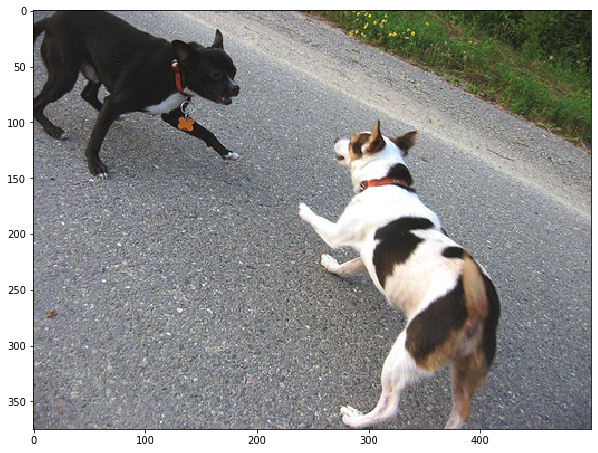

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
# Для чтения изображений из файлов мы будем использовать библиотеку cv2 --> всё что вам нужно знать
#   функция cv2.imread(path) принимает на вход путь к файлу изображения и возвращает np.array с изображением
#   в порядке h x w x c
image = cv2.imread(os.path.join(data_folder, 'train', '0001.png'))
print(type(image))
print(image.shape)
plt.imshow(image)
plt.show()

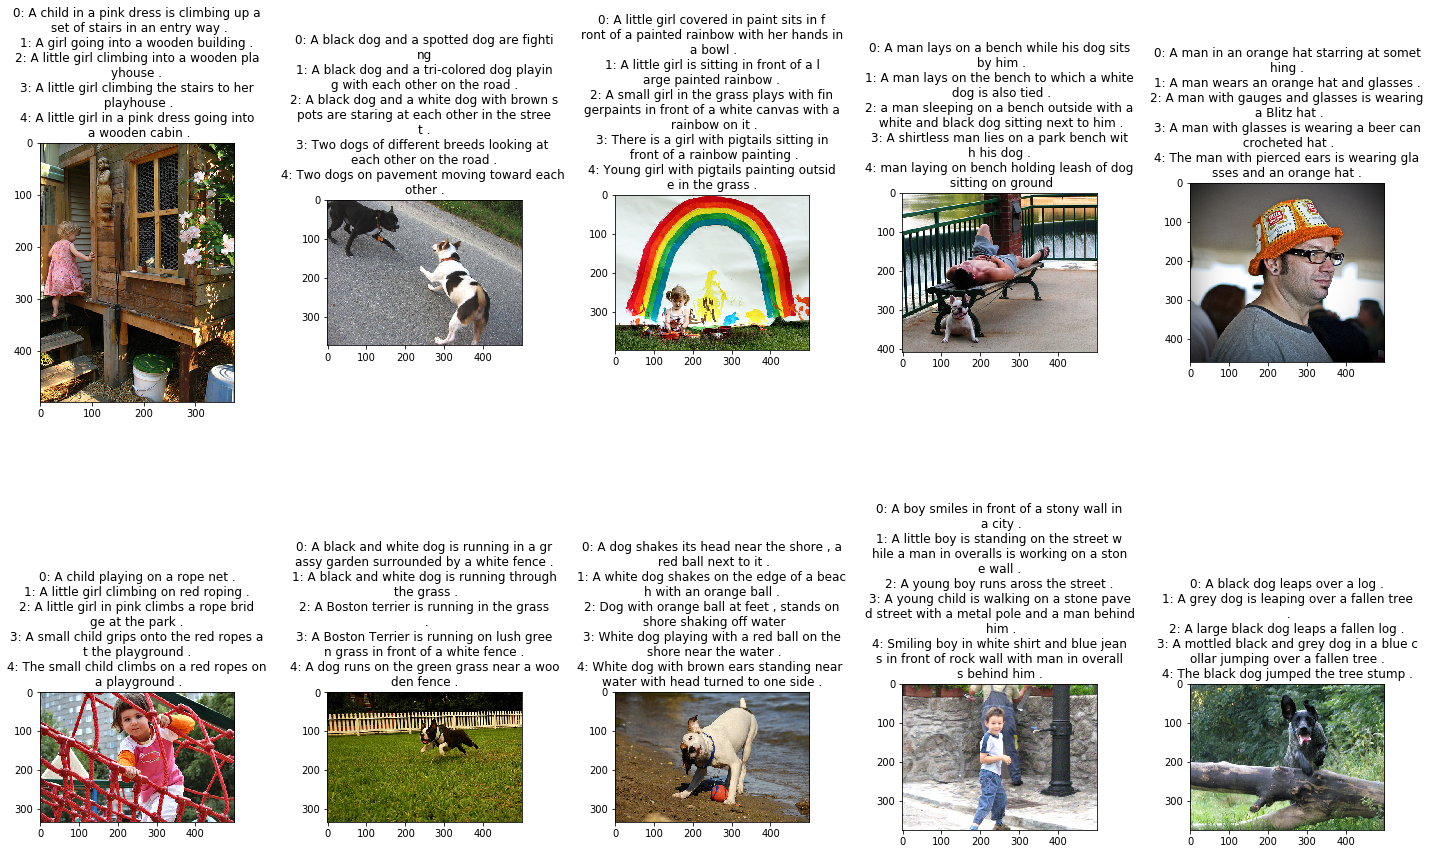

In [101]:
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    captions = [row[f'caption #{i}'] for i in range(5)]
    
    caption_adjasted = map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions))
    caption = '\n'.join(caption_adjasted)
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(cv2.imread(os.path.join(data_folder, split, img_id)))

fig.tight_layout()
plt.show()

### 1.2 Предобработка изображений

**Сперва напишем предобработку для изображений**

In [102]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr

In [103]:
import glob
from itertools import chain

all_pth = list(chain.from_iterable([glob.glob('./data/train/*'), glob.glob('./data/val/*')]))

In [105]:
# Посчитайте поканальные mean и std для всех изображений из train (здесь можете так же использовать и val датасет)

channel_mean = 0
channel_std = 0
for pth in tqdm(all_pth):
    mean, std = cv2.meanStdDev(cv2.imread(pth, cv2.IMREAD_ANYCOLOR))
    channel_mean += mean
    channel_std += std

channel_mean = channel_mean.flatten() / len(all_pth)
channel_std = channel_std.flatten() / len(all_pth)

print(channel_mean, channel_std)


[116.76792485 113.76025547 102.92506461] [61.66282124 59.39666624 60.41963516]


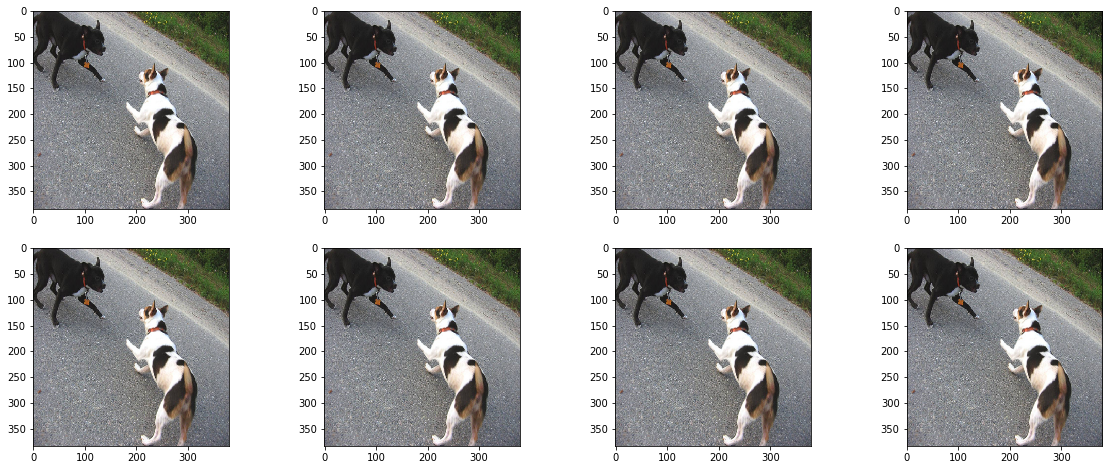

In [106]:
# Напишите функцию для предобработки одного изображения

image_prepare = tr.Compose([
    #tr.ToPILImage(), # выключу, т.к. не оч понятно зачем это нужно
    tr.ToTensor(),
    tr.Resize(size=(384, 380), antialias=None), # efficientnet_b4
    tr.Normalize(channel_mean, channel_std),
])

augs = tr.Compose([
    tr.RandomHorizontalFlip(p=0.1),  # it may affect image - caption relations
    
])

image = cv2.imread(os.path.join(data_folder, "train", "0001.png"))

def de_normalize(img):
    inverse = tr.Compose([
        tr.Normalize([0, 0, 0], 1 / channel_std),
        tr.Normalize(-channel_mean, [1, 1, 1]),
    ])
    return inverse(img).clip(0, 1)


fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    transformed_image = image_prepare(image)
    plt.imshow(de_normalize(transformed_image).numpy().transpose(1, 2, 0))
plt.show()

### 1.3 Предобработка заголовков

**Затем напишем предобработку для заголовков**

Для простоты вычислений предлагаю сделать крайне простую токенизацию, пользуясь регулярными выражениями и библиотекой **re**

1. Приводим текст к нижнему регистру
2. Заменяем всю пунктуацию на пробелы
3. Убираем пробельные символы с концов строки
4. Разбиваем по ненулевой последовательности пробельных символов
5. Добавляем специальные токены \<BOS> (begin of sentence) и \<EOS> (end of sentence), чтобы обозначить границы заголовка для модели

In [107]:
import re

def tokenize(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z0-9]", ' ', text)
    text = text.lstrip().rstrip() # это вообще говоря не обзятельно
    
    tokens = ['<BOS>']
    tokens.extend(text.split())
    tokens.append('<EOS>')
    
    return tokens

In [108]:
exmpl = ' , GOOD-_ moRning!    ... '
tokenize(exmpl)

['<BOS>', 'good', 'morning', '<EOS>']

Соберём словарь из всех слов, что встречаются в заголовках в train
1. Токенизируем заголовки
2. Обновляем частоту всех отдельных токенов
3. Выкидываем все слова с частотой не больше минимума (допустим 3 - можете взять другое число) -> заменяем на специальный \<UNK> (unknown) токен
4. Записываем быстрое преобразование из токенов в индексы и наоборот

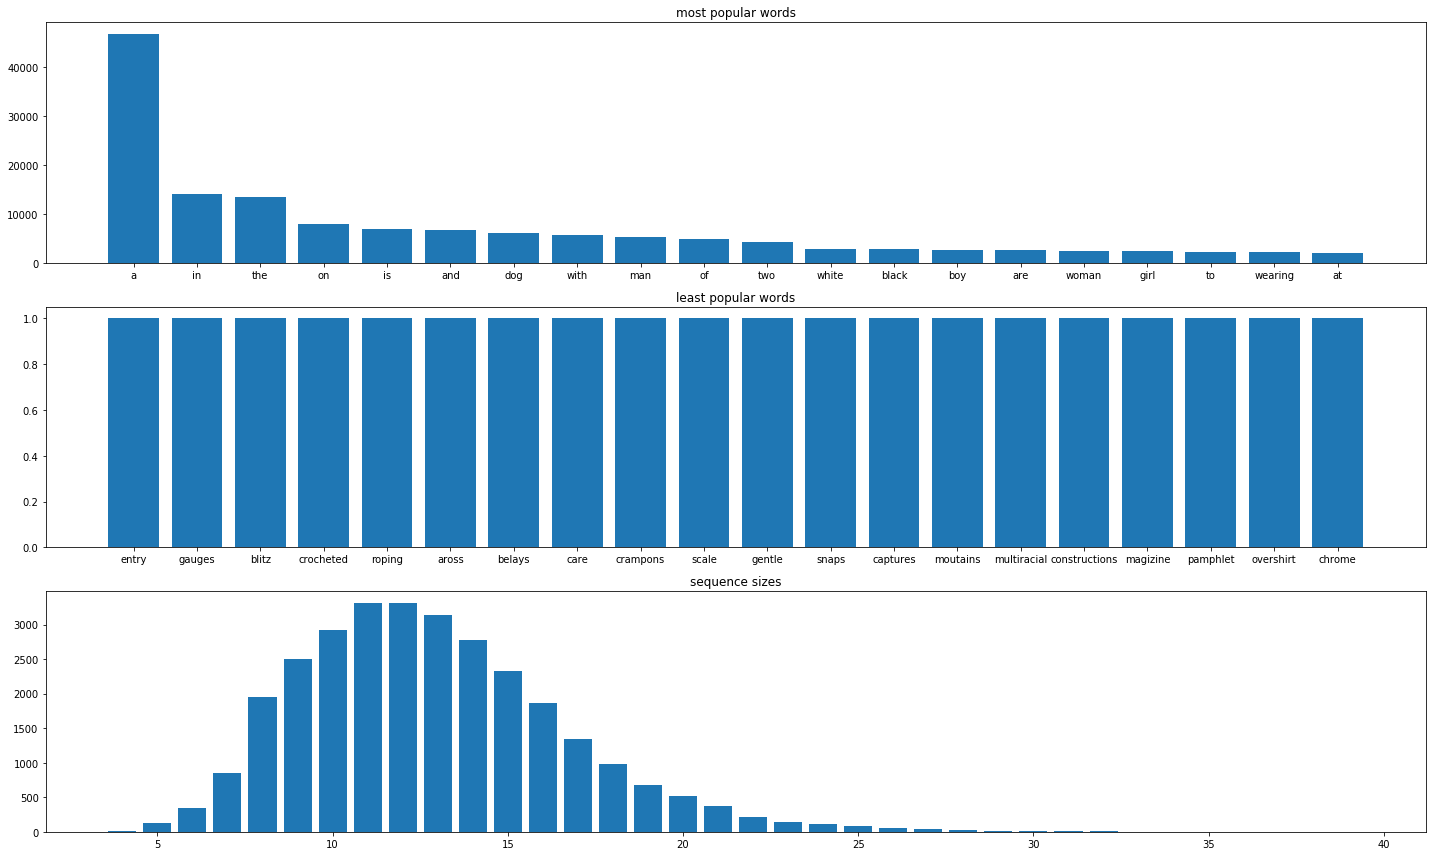

In [109]:
from tqdm.notebook import trange
from collections import defaultdict

vocab_freq = defaultdict(int)

# Параллельно заодно посчитаем длины заголовков в токенах (сколько раз встречалась какая длина в токенах) 
#   так же здесь можно использовать val при желании
sizes = defaultdict(int)
for _, captions in tqdm(dfs['train'].iterrows()):
    for caption in captions[1:]:
        tokens = tokenize(caption)
        sizes[len(tokens)] += 1
        
        for token in tokens:
            vocab_freq[token] += 1
            
            
# удалим технические токены из частотного словаря
vocab_freq.pop('<BOS>')
vocab_freq.pop('<EOS>')


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!ОБРАТИ ВНИМАНИЕ!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_seq_len = np.max(list(sizes.keys()))
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


show_ = 20
fig, ax = plt.subplots(3, 1, figsize=(20, 12))

plt.subplot(312)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1])}
plt.title('least popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(311)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)}
plt.title('most popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(313)
plt.title('sequence sizes')
plt.bar(list(sizes.keys()), list(sizes.values()))

fig.tight_layout()
plt.show()
    

In [110]:
# Так же добавляем <PAD> токен для паддингов
from itertools import count
tok_to_ind = {
    '<UNK>': 0,
    '<BOS>': 1,
    '<EOS>': 2,
    '<PAD>': 3,
}

ind_to_tok = {
    0: '<UNK>',
    1: '<BOS>',
    2: '<EOS>',
    3: '<PAD>',
}


min_occurences = 4
indices_factory = count(start=4)
for token, occurs in vocab_freq.items():
    if occurs >= min_occurences:
        idx = next(indices_factory)
        ind_to_tok[idx] = token
        tok_to_ind[token] = idx


assert len(tok_to_ind) == len(ind_to_tok)
vocab_size = len(tok_to_ind)
print(vocab_size)

2917


In [111]:
# Функция возвращает по тексту индексы токенов в тексте
def to_ids(text):
    return [tok_to_ind.get(tok, 0) for tok in tokenize(text)]

In [112]:
text = "Some random text I wrote. And the one, that cann't be forgotten unless I'll decide that... Tho it's still great"
toks = tokenize(text)
ids = to_ids(text)
print(toks)
print(ids)
assert toks[0] == '<BOS>' and toks[-1] == '<EOS>'
assert ids[0] == tok_to_ind['<BOS>'] and ids[-1] == tok_to_ind['<EOS>']

['<BOS>', 'some', 'random', 'text', 'i', 'wrote', 'and', 'the', 'one', 'that', 'cann', 't', 'be', 'forgotten', 'unless', 'i', 'll', 'decide', 'that', 'tho', 'it', 's', 'still', 'great', '<EOS>']
[1, 104, 0, 0, 1372, 0, 9, 6, 60, 153, 0, 266, 498, 0, 0, 1372, 0, 0, 153, 0, 157, 158, 1540, 2469, 2]


### 1.4 Датасет

**Сделаем класс датасета в стиле torch.utils.data.Dataset**

In [113]:
import torch 

class ImageCaptioningDataset(Dataset):
    """
        imgs_path ~ путь к папке с изображениями
        captions_path ~ путь к .tsv файлу с заголовками изображений
    """
    def __init__(self, imgs_path, captions_path, transforms, augs=None):
        super(ImageCaptioningDataset).__init__()
        # Читаем и записываем из файлов в память класса, чтобы быстро обращаться внутри датасета
        # Если не хватает памяти на хранение всех изображений, то подгружайте прямо во время __getitem__, но это замедлит обучение
        # Проведите всю предобработку, которую можно провести без потери вариативности датасета, здесь
        
        captions = pd.read_csv(captions_path, sep='\t')
        self.images_pth = [
            os.path.join(imgs_path, fname)
                for fname in captions['img_id']
        ]
        
        self.in_seqs = []
        self.out_words = []
        for _, caption in captions.iterrows():
            seqs, words = zip(*map(self.make_seq, caption[1:]))
            self.in_seqs.append(torch.vstack(list(chain.from_iterable(seqs))))
            self.out_words.append(torch.vstack(list(chain.from_iterable(words))))
        
        self.augs = augs
        self.transforms = transforms

    def __getitem__(self, index):
        # Получаем предобработанное изображение
        
        # Получаем по каждому заголовку набор in текстов - out слов
        #   в каждом заголовке берём всевозможные не пустые префиксы как in и следующее за префиксом слово как out
        #   применяем padding ко всем текстам в in (слева или справа?)
        #   in_seqs: torch.tensor \in [\sum{len(caption_i) - 1}; max_seq_len or local_max_seq_len]
        #   out_words: torch.tensor \in [\sum{len(caption_i) - 1}]
        
        img = self.transforms(cv2.imread(self.images_pth[index], cv2.IMREAD_ANYCOLOR))
        in_seqs = self.in_seqs[index]
        out_words = self.out_words[index]
        if self.augs:
            img = self.augs(img)
        
        return img, in_seqs, out_words
    
        
    def __len__(self):
        return len(self.images_pth)
    
    @staticmethod
    def make_seq(text):
        token_ids = to_ids(text)

        seqs = torch.full((len(token_ids) - 1, max_seq_len), fill_value=tok_to_ind['<PAD>'], dtype=torch.int64)
        words = torch.zeros(len(token_ids) - 1,  dtype=torch.int64)
        for i in range(1, len(token_ids)):
            seqs[i - 1, :i] = torch.tensor(token_ids[:i], dtype=torch.int64)
            words[i - 1] = token_ids[i]

        return seqs, words


In [121]:
ds_train = ImageCaptioningDataset(
        os.path.join(data_folder, 'train'), 
        os.path.join(data_folder, f'captions_train.tsv'),
        transforms=image_prepare,
        augs=augs
)
ds_val = ImageCaptioningDataset(
        os.path.join(data_folder, 'val'), 
        os.path.join(data_folder, f'captions_val.tsv'),
        transforms=image_prepare,
        augs=augs           
)

In [115]:
img_, in_seqs_, out_words_ = ds_train[0]

assert isinstance(img_, torch.Tensor)
assert isinstance(in_seqs_, torch.Tensor)
assert isinstance(out_words_, torch.Tensor)

assert img_.shape[0] == 3
assert in_seqs_.shape[0] == out_words_.shape[0]
assert ind_to_tok[out_words_[-1].item()] == "<EOS>"

assert ds_train.__len__() == len(os.listdir(os.path.join(data_folder, 'train')))
assert ds_val.__len__() == len(os.listdir(os.path.join(data_folder, 'val')))

print(img_.shape)
print(in_seqs_.shape)
print(out_words_.shape)

/kernel/lib/python3.8/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


torch.Size([3, 384, 380])
torch.Size([58, 39])
torch.Size([58, 1])


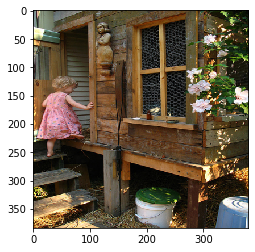

In [116]:
# Sanity check
plt.imshow(
    de_normalize(img_).numpy().transpose(1, 2, 0)
)
plt.show()

In [117]:
# Только если вы возвращаете сразу группу, если вы возвращаете в __getitem__ один элемент, то просто игнорируйте этот блок
k = 10

# Для паддингов справа
# Здесь должна быть лесенка, если вы не перемешиваете дополнительно зачем-то in_seqs в __getitem__
print(in_seqs_[:k+1,:k+1].numpy())
print('\n')
# А тут вы должны узнать эти числа из матрицы выше
print('    ', out_words_[:k].numpy())


# Для паддингов слева
# Здесь должна быть лесенка
print(in_seqs_[:k+1,-k-1:].numpy())
print('\n')
# А тут вы должны узнать эти числа из матрицы выше
print('    ', out_words_[-k:].numpy())

[[  1   3   3   3   3   3   3   3   3   3   3]
 [  1   4   3   3   3   3   3   3   3   3   3]
 [  1   4  44   3   3   3   3   3   3   3   3]
 [  1   4  44   5   3   3   3   3   3   3   3]
 [  1   4  44   5   4   3   3   3   3   3   3]
 [  1   4  44   5   4  89   3   3   3   3   3]
 [  1   4  44   5   4  89 173   3   3   3   3]
 [  1   4  44   5   4  89 173   8   3   3   3]
 [  1   4  44   5   4  89 173   8 118   3   3]
 [  1   4  44   5   4  89 173   8 118  54   3]
 [  1   4  44   5   4  89 173   8 118  54   4]]


     [[  4]
 [ 44]
 [  5]
 [  4]
 [ 89]
 [173]
 [  8]
 [118]
 [ 54]
 [  4]]
[[3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3]]


     [[  5]
 [  4]
 [ 89]
 [173]
 [317]
 [ 66]
 [  4]
 [198]
 [  0]
 [  2]]


### 1.5 Даталоадер

In [118]:
# Сложим батч в следующем виде:
#   img_batch: [bs, c, h, w]
#   in_seqs_batch: [\sum_{i \in range(bs)}(\sum(seq_lens)_i), max_seq_len or local_max_seq_len]
#   out_words_batch: [\sum_{i \in range(bs)}(\sum(seq_lens)_i)]
#   text_to_image_align: [bs] --> число строк в in_seqs_batch и out_words_batch, соответствующих картинке

def collate_fn(batch):
    img_batch = torch.stack([img for img, *_ in batch])
    in_seqs_batch = torch.vstack([in_seqs for _, in_seqs, _ in batch])
    out_words_batch = torch.vstack([out_word for _, _, out_word in batch])
    
    text_to_image_align = torch.tensor([in_seqs.shape[0] for _, in_seqs, _ in batch], dtype=torch.int64)
    
    return img_batch, in_seqs_batch, out_words_batch, text_to_image_align

In [119]:
batch_size = 32

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [120]:
img_batch, in_seqs_batch, out_words_batch, text_to_image_align = next(iter(dataloader_train))

assert isinstance(img_batch, torch.Tensor)
assert isinstance(in_seqs_batch, torch.Tensor)
assert isinstance(out_words_batch, torch.Tensor)
assert isinstance(text_to_image_align, torch.Tensor)

assert img_batch.shape[:2] == torch.Size([batch_size, 3])
assert in_seqs_batch.shape[0] == out_words_batch.shape[0]
assert text_to_image_align.shape[0] == batch_size
assert text_to_image_align.sum() == in_seqs_batch.shape[0]

assert in_seqs_batch.dtype in {torch.int64, torch.LongTensor}
assert out_words_batch.dtype in {torch.int64, torch.LongTensor}
assert text_to_image_align.dtype in {torch.int64, torch.LongTensor}

print(img_batch.shape, in_seqs_batch.shape, out_words_batch.shape, text_to_image_align.shape, sep="\n")

torch.Size([32, 3, 384, 380])
torch.Size([1889, 39])
torch.Size([1889, 1])
torch.Size([32])


## 2. Составляем модель (***3 балла***)

Если картинка не появляется, то откройте блок и перейдите по ссылке внутри.

![модель](лаба1_модель.png "Модель")

<img src=https://disk.yandex.ru/i/ZvTuLzSe4TGWmQ alt="Модель" width="30%" height="200"/>

### 2.1 Фича-экстрактор для изображений

Возьмите какую-нибудь предобученную модель (к примеру resnet), по желанию заморозьте все или часть слоёв, наиболее вероятно уберите последний слой

In [122]:
from torchvision import models
from torch import nn

In [123]:
class img_fe_class(nn.Module):
    # ------------ ИЗМЕНИЛ МОДЕЛЬ - СДЕЛАЙ РЕСАЙЗ В ТРАНСФОРМЕ
    def __init__(self):
        super(img_fe_class, self).__init__()
        self.img_fe = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        self.img_fe.classifier = nn.Identity()
        self.img_fe.requires_grad_(False)
        
    def forward(self, imgs):
        return self.img_fe(imgs)

In [128]:
img_fe = img_fe_class()
    
feat_img = img_fe(img_[None,:,:,:])

assert len(feat_img.shape) == 2
assert feat_img.shape[0] == 1

print(f'outputs {feat_img.shape[1]} features from feature extractor')
print(feat_img.shape)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 105MB/s] 


outputs 1792 features from feature extractor
torch.Size([1, 1792])


### 2.2 Фича-экстрактор для текста

Давайте скачаем предобученные glove вектора и инициализируем nn.Embedding ими, там где мы их знаем

#!c1.4:bash
ls -sh glove.*

In [125]:
#!g1.1
import numpy as np
# Открываем glove
np.random.seed(19)

def load_glove_weights(file_path, vocab, pad_token="<PAD>"):
    print("Loading Glove Weights")
    # Инициализируем веса для всех слов стандартным нормальным распределением
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)
    
    with open(file_path, 'r') as f:
        for line in tqdm(f, total=400001):
            line = line.split()
            token = ' '.join(line[:-300])
            embed = line[-300:]

            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=np.float)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab[pad_token]] = np.zeros(300, dtype=np.float)
    return glove_weights, mask_found


glove_path = "./glove.6B.300d.txt"
glove_weights, mask_found = load_glove_weights(glove_path, tok_to_ind, "<PAD>")

Loading Glove Weights



2901 words from vocab of size 2917 loaded!


In [126]:
class text_fe_class(nn.Module):
    def __init__(self,
        vocab_size: int,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int,
        bidirectional: bool,
        freeze_glove=True,
        reduce: str = 'last',
    ):
        super(text_fe_class, self).__init__()
        self.reduce = reduce
        
        assert input_size == 300 

        self.embed = self.embed = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=input_size
        )

        self.embed.weight = nn.Parameter(
            torch.from_numpy(glove_weights),
            requires_grad = (not freeze_glove)
        )
        
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=0.05,
            batch_first=True,
        )
        
        D = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * D, output_size)
        
    def forward(self, in_seqs):
        in_seqs = self.embed(in_seqs)
        
        output, (hn, cn) = self.rnn(in_seqs.float())
        
        if self.reduce == 'last':
            output = output[:, -1, :]
        elif self.reduce == 'mean':
            output = output.mean(1)
        elif self.reduce == 'max':
            output = output.max(1)
        elif self.reduce == 'sum':
            output = output.sum(1)
        
        output = self.fc(output)
        
        return output

In [127]:
text_fe = text_fe_class(
    vocab_size=len(tok_to_ind),
    input_size=300,
    hidden_size=120,
    output_size=max_seq_len,
    num_layers=4,
    bidirectional=False,
)
feat_text = text_fe(in_seqs_)

assert in_seqs_.shape[0] == feat_text.shape[0]
assert len(feat_text.shape) == 2, 'По каждому тексту вам нужен один вектор, а RNN блок возвращает output для каждого шага seq_len, не забудьте как-то это исправить'

print(in_seqs_.shape)
print(feat_text.shape)

torch.Size([58, 39])
torch.Size([58, 39])


### 2.3 Финальная модель

Сконкатенируйте полученные фичи и подайте в линейный слой (лучше сделать хотя 2 линейных слоя для большей гибкости).

Так же подумайте какие ещё блоки / слои тут могут быть нужны.

In [ ]:
from collections import OrderedDict

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

class image_captioning_model(nn.Module):
    def __init__(self, img_fe, text_fe, device=device, features_input_size=1831):
        super(image_captioning_model, self).__init__()
        self.img_fe = img_fe
        self.text_fe = text_fe
        self.device = device
        
        self.bn = nn.BatchNorm1d(features_input_size)
        
        self.fc = nn.Sequential(OrderedDict([
            ('in2hid', nn.Linear(features_input_size, hid_size)),
            ('act', nn.ReLU()),
            ('drop', nn.Dropout(dropout_p)),
            ('bnorm', nn.BatchNorm1d(hid_size)),
            ('hid2out', nn.Linear(hid_size, vocab_size)),
            ('log_soft', nn.LogSoftmax(dim=-1)),
        ]))
        
    def forward(self, img_batch, in_seqs_batch, text_to_image_align):
        img_features = self.img_fe(img_batch)
        text_features = self.text_fe(in_seqs_batch)
        img_aligned = torch.repeat_interleave(img_features, text_to_image_align)
    
        out = torch.cat([img_aligned, text_features], dim=1)
        
        out = self.bn(out)
        out = self.fc(out)
        
        return out

In [140]:
a = torch.rand(10, 200)

In [141]:
b = torch.randint(1, 3, (10,))

In [143]:
torch.repeat_interleave(a, repeats=b, dim=0)

tensor([[0.9940, 0.7822, 0.2191,  ..., 0.2873, 0.0121, 0.9909],
        [0.9940, 0.7822, 0.2191,  ..., 0.2873, 0.0121, 0.9909],
        [0.6182, 0.6534, 0.5149,  ..., 0.8390, 0.0256, 0.2085],
        ...,
        [0.3798, 0.8236, 0.6300,  ..., 0.6182, 0.5135, 0.5493],
        [0.6989, 0.2217, 0.0331,  ..., 0.5400, 0.2539, 0.7804],
        [0.5948, 0.5592, 0.2119,  ..., 0.8383, 0.5846, 0.8374]])

In [ ]:
model = image_captioning_model(img_fe, text_fe).float().to(device)

res = model(img_batch, in_seqs_batch, text_to_image_align)

assert res.shape[0] == np.sum(out_words_batch.shape[0])
assert res.shape[1] == vocab_size

print(res.shape)

In [ ]:
from termcolor import colored

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

# Считаем общее число параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        param[0],
                        beautiful_int(num_params),
                        param[1].requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
        sum_params += num_params
        if param[1].requires_grad:
            sum_learnable_params += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    return sum_params, sum_learnable_params


sum_params, sum_learnable_params = model_num_params(model)

## 3. Пайплайн обучения (***3 балла***)

### 3.1 Оптимайзер

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, ..., device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer = ...
    return model, optimizer

# Убедитесь что всё сработало и создалось нормально и без ошибок
model, optimizer = create_model_and_optimizer(
    ...
)

### 3.2 Один шаг обучения/валидации

In [ ]:
#!g1.1
from collections import defaultdict

def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
        optimizer.zero_grad()
        pred = ...
        loss = ...
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
            pred = ...
            loss = ...

            losses_val.append(loss.item())
            
            # Можете добавить сюда любые метрики, которые хочется (см. код здесь и 3.3 за подробностями)
            if metric_names is not None:
                if 'accuracy' in metric_names:
                    preds = torch.argsort(pred, dim=1, descending=True)
                    for k in metric_names["accuracy"]["top"]:
                        metrics[f'accuracy ~ top#{k}'].append(
                            np.mean([out_words_batch[i].item() in preds[i, :k] for i in range(out_words_batch.shape[0])])
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

### 3.3 Цикл обучения

In [ ]:
#!g1.1
from IPython.display import clear_output
import warnings

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
    save_only_best=True,
):
    if model_name is None:
        if os.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    
    if os.exists(os.path.join(chkp_folder, model_name)):
        model_name = model_name + "_v2"
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    os.makedirs(os.path.join(chkp_folder, model_name))
    
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)
            
            # Сохраняем лучшую по валидации модель
            if ((not save_only_best) or (loss < best_val_loss)):
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join('./checkpoints', model_name, f'{model_name}#{epoch}.pt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot id", 1)]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append(el[0])
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys in plot_ids.items():
                    for key in keys:
                        plt.subplot(1, ww + ww_metrics, ww + plot_id)
                        plt.title(f'additional metrics #{plot_id}')
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                        plt.legend()
                        plt.grid()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

### 3.4 Обучаем модель

In [ ]:
#!g1.1
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

img_fe = img_fe_class()
text_fe = text_fe_class()

model, optimizer = create_model_and_optimizer(
    model_class = image_captioning_model,
    model_params = {
        'img_fe': img_fe,
        'text_fe': text_fe,
        'hid_size': 1024,
        'dropout_p': 0.3,
    },
    lr = 1e-3,
    device = device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion = nn.NLLLoss()

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
)

In [ ]:
#!g1.1
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

img_fe = ...
text_fe = ...

model, optimizer = create_model_and_optimizer(
    ...
)

scheduler = ...

criterion = ...

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "left_pad",
    save_only_best=True,
)

### 3.5 Загрузка чекпоинта

#### **Не запускайте этот блок, если не понимаете для чего это в данную секунду!**

#### **Так можно случайно перезатереть несколько часов вычислений, если не скопировать их в отдельную переменную/чекпоинт**

In [ ]:
#!g1.1
assert False, "Are you sure? If not - stop right here, otherwise - comment this assert line"


chkp_folder = ...
model_name = ...
epoch = ...
checkpoint = torch.load(os.path.join(chkp_folder, model_name, f'{model_name}#{epoch}.pt'))

# Создаём те же классы, что и внутри чекпоинта
model, optimizer = create_model_and_optimizer(
    ...
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

# Загружаем состояния из чекпоинта
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']

## 4. Оценка результатов (***2 балл***)

### 4.1 Генерация

In [ ]:
#!g1.1
from typing import Optional

def generate(
    model,
    image,
    max_seq_len: Optional[int] = max_seq_len,
    top_p: Optional[float] = None,
    top_k: Optional[int] = None,
) -> str:
    """
    По картинке image генерируете текст моделью model либо пока не сгенерируете '<EOS>' токен, либо пока не сгенерируете max_seq_len токенов
        top_k -> после получения предсказания оставляете первые top_k слов и сэмплируете случайно с перенормированными вероятностями из оставшихся слов
        top_p -> после получения предсказания оставляете первые сколько-то слов, так, чтобы суммарная вероятность оставшихся слов была не больше top_p,
            после чего сэмплируете с перенормированными вероятностями из оставшихся слов
        иначе -> сэмплируете случайное слово с предсказанными вероятностями
    """
    assert top_p is None or top_k is None, "Don't use top_p and top_k at the same time"
    
    model.eval()
    
    with torch.no_grad():
        ...

### 4.2 Посмотрим на предсказания модели

In [ ]:
#!g1.1
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))
    
    pred_caption = generate(model, img, max_seq_len=..., top_p=..., top_k=...)
    pred_caption = '\n'.join([pred_caption[k:k+title_width] for k in range(0, len(pred_caption), title_width)])
    
    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = list(map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions)))
    
    caption = '\n'.join(['pred:\n' + pred_caption + '\n\n'] + caption_adjasted)
    
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

In [ ]:
#!g1.1
inds = list(range(10))
split = 'val'

h, w = 2, 5
title_width = 43

top_p = None
top_k = 3

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))
    
    pred_caption = generate(model, img, max_seq_len=..., top_p=..., top_k=...)
    pred_caption = '\n'.join([pred_caption[k:k+title_width] for k in range(0, len(pred_caption), title_width)])
    
    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = list(map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions)))
    
    caption = '\n'.join(['pred:\n' + pred_caption + '\n\n'] + caption_adjasted)
    
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

### 4.3 BLEU на всём val датасете

In [ ]:
#!g1.1
from torchtext.data.metrics import bleu_score

def get_bleu(model, max_seq_len=max_seq_len, top_p=None, top_k=None, split="val"):
    candidates = []
    references = []
    ...

    return bleu_score(candidates, references)

In [ ]:
#!g1.1
# При сдаче задания - напишите в комментарий к работе свой скор из вот этой ячейки
bleu_res = get_bleu(model, max_seq_len=..., top_p=..., top_k=..., split="val")
print(bleu_res)

## 5. Эксперименты (***3+ баллов***)

В этой части у вас не будет никакого написанного мною кода, а всё что вы здесь будете делать - на ваше усмотрение и по вашей задумке

Цель эксперментов:
**Пройти порог BLEU score на валидации (только делайте это честно, если где-то валидация будет протекать в обучение - 0 баллов за всё задание не думая)**

В блоке 4.3 при подсчёте BLEU на Val датасете вам нужно преодолеть следующие пороги:

**0.1** --> **1 балл**

**0.2** --> **2 балла**

**0.25** --> **3 балла**

В зависимости от решений других студентов пороги могут измениться, а за самые лучшие решения мы можем добавить дополнительные баллы. Эти дополнительные баллы не могут перейти на другие домашки, но могут помочь компенсировать потерянные в ходе именно этой лабораторной баллы в других частях.

**Так же важно:**
1. Процесс обучения данной модели должен находиться в данном ноутбуке в разделах 1-5, чтобы мы видели что чекпоинт правда ваш и написан/обучен вами.
2. Все эксперименты должны быть задокументированы: что вы пробовали, почему, какие результаты получили. Старайтесь максимально качественно описывать все свои эксперименты, потому что за отсутствие или за низкого качества описания экспериментов могут сниматься баллы. 

___Рисуйте графики, таблицы, не забывайте про то, что несколько графиков можно уместить в одном поле вывода, подписывайте оси, пишите заголовки.___

___Простой тест для самих себя - откройте свой ноутбук и дальше читайте только markdown-поля и выводы ячеек, но не сами ячейки с кодом.___

___Если, сделав это, вы не смогли понять что делалось в ноутбуке и какие результаты были получены - что-то явно не так и такого рода работа точно является кандидатом под снижение баллов за оформление и документацию экспериментов.___

___Так же старайтесь сделать оформление работы чистым при сдаче - мы можем снизить баллы, если общее качество оформления будет низким, т.к. проверять работы мы будем вручную.___


### **Удачи!**

In [ ]:
#!g1.1
